In [1]:
%pip install tsmoothie
%pip install catboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
from ipyleaflet import Map, Marker
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
from tsmoothie.utils_func import sim_randomwalk
from tsmoothie.smoother import LowessSmoother, KalmanSmoother
from tsmoothie.bootstrap import BootstrappingWrapper
import xarray as xr

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
from catboost import CatBoostClassifier, Pool

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('d2de6b1461274bc0b832979219b018a9')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

In [16]:
#py kernel must be in same location as data directory
crop_presence_data = pd.read_csv("PlanetaryComputerExamples/OpenDataChallenge/Data/Crop_Location_Data_20221201.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


In [17]:
def create_bbox(lat_long, size_px):
    
    box_size_deg = 0.00007 * size_px 

    min_lon = lat_long[1]-box_size_deg/2
    min_lat = lat_long[0]-box_size_deg/2
    max_lon = lat_long[1]+box_size_deg/2
    max_lat = lat_long[0]+box_size_deg/2

    bbox = (min_lon, min_lat, max_lon, max_lat)
    return bbox

def smooth_data(data, window_size=3):
    data = data.rolling(window_size, center=True).mean()
    return data

def db_scale(x):
    return 10 * np.log10(x)

In [18]:
def get_sentinel_data(latlong, time_slice,assets, bbox_size_px = 5):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''
    
    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    bbox = create_bbox([float(latlong[0]),float(latlong[1])], bbox_size_px)
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    bands_of_interest = assets
    data = stac_load(items, bands = bands_of_interest, patch_url=pc.sign, bbox=bbox) 
    return data

In [9]:
time_slice = "2020-01-04/2021-01-04"
assets = ['vh','vv']
coordinates=crop_presence_data['Latitude and Longitude']
datasets = []
for i in tqdm(range(0,len(coordinates))):
    data = db_scale(get_sentinel_data(coordinates[i],time_slice,assets, bbox_size_px = 5))
    data.mean(dim=['x','y']).compute()
    data.to_netcdf('./Data/RawData/raw_data_' + str(i) + '.nc')
    datasets.append(data)


100%|██████████| 5/5 [01:39<00:00, 19.95s/it]


Relevant data has been downloaded, now Preprocessing

In [71]:
#get sample data from Data/RawData files
dataArray = []
for i in tqdm(range(0,600)):
    data = xr.open_dataset('PlanetaryComputerExamples/OpenDataChallenge/Data/RawData/raw_data_'+str(i)+'.nc')
    data = data.mean(dim=['x','y']).compute()
    dataArray.append(data)
data = xr.concat(dataArray, dim='place')

100%|██████████| 600/600 [00:04<00:00, 143.14it/s]


In [72]:
#fills in missing data with the mean of the previous and next value
data = data.resample(time='1D').max()


In [73]:
data

<xarray.Dataset>
Dimensions:      (time: 361, place: 600)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-09 2020-01-10 ... 2021-01-03
    spatial_ref  int32 32648
Dimensions without coordinates: place
Data variables:
    vh           (place, time) float32 -15.35 nan nan nan ... nan -12.58 -12.66
    vv           (place, time) float32 -10.2 nan nan nan ... nan -6.482 -6.339

In [75]:
#interpolates missing data
data = data.interpolate_na(dim='time', method='cubic')

Here i choose VH/VV as a third variable for interpreting satellite data
This is a important feature since it signifies volumetric scattering = vegetation

In [76]:
#add cross-co polarisation
crossCo = (data.vh/data.vv).to_dataset(name='crossCo')
data = data.merge(crossCo)

In [77]:
data

<xarray.Dataset>
Dimensions:      (time: 361, place: 600)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-09 2020-01-10 ... 2021-01-03
    spatial_ref  int32 32648
Dimensions without coordinates: place
Data variables:
    vh           (place, time) float32 -15.35 -14.49 -14.31 ... -12.58 -12.66
    vv           (place, time) float32 -10.2 -9.7 -9.615 ... -6.482 -6.339
    crossCo      (place, time) float32 1.506 1.494 1.488 ... 2.012 1.941 1.998

In [78]:
#apply time series smoothing
smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
smooth_data = []	
for i in tqdm(range(0,len(data.place))):
    smoother.smooth(data.isel(place=i).to_array(dim='time'))
    smooth_data.append(xr.DataArray(smoother.smooth_data, dims=['bands', 'time'], coords={'bands':['vv','vh','crossCo'], 'time':data.time}))


smooth_data = xr.concat(smooth_data, dim='place')

 

100%|██████████| 600/600 [00:14<00:00, 42.05it/s]


In [65]:
smooth_data

<xarray.DataArray (place: 1, bands: 3, time: 361)>
array([[[-15.729382 , -15.845551 , -15.949117 , ..., -21.990608 ,
         -21.990892 , -21.98595  ],
        [-10.406672 , -10.482129 , -10.552337 , ..., -10.4397545,
         -10.323321 , -10.234893 ],
        [  1.5081503,   1.5087985,   1.5090792, ...,   2.1085167,
           2.1161609,   2.1185954]]], dtype=float32)
Coordinates:
  * bands    (bands) <U7 'vv' 'vh' 'crossCo'
  * time     (time) datetime64[ns] 2020-01-09 2020-01-10 ... 2021-01-03
Dimensions without coordinates: place

Text(0.5, 0, 'time')

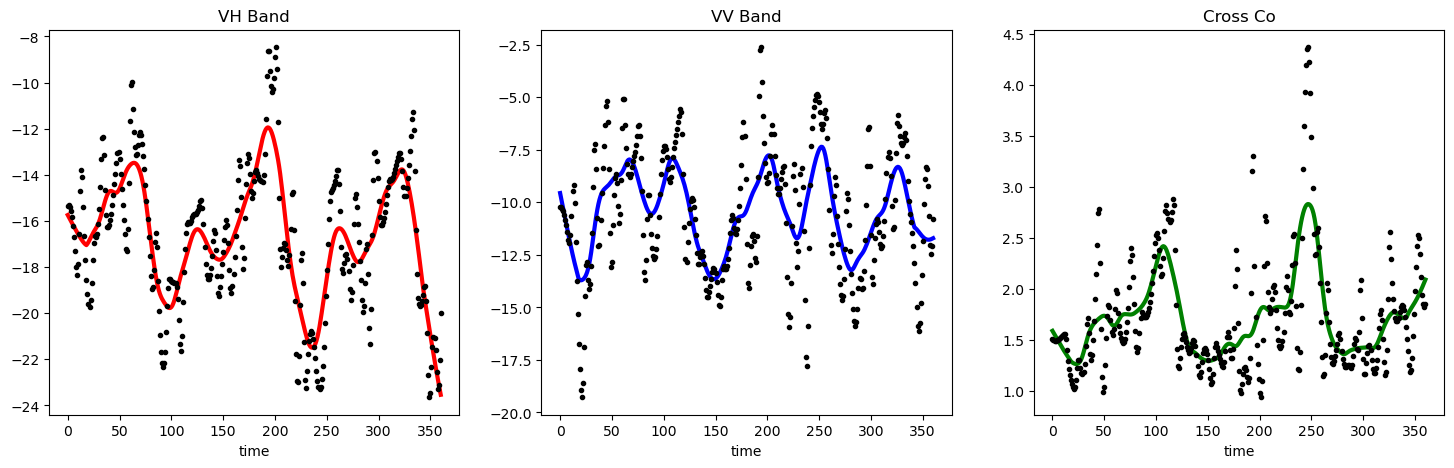

In [68]:
# plot the smoothed timeseries with intervals
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(smoother.smooth_data[0], linewidth=3, color='red')
plt.plot(smoother.data[0], '.k')
plt.title(f"VH Band"); plt.xlabel('time')


#plot for vv band
plt.subplot(1,3,2)
plt.plot(smoother.smooth_data[1], linewidth=3, color='blue')
plt.plot(smoother.data[1], '.k')
plt.title(f"VV Band"); plt.xlabel('time')


#plot for cross copolarization
plt.subplot(1,3,3)
plt.plot(smoother.smooth_data[2], linewidth=3, color='green')
plt.plot(smoother.data[2], '.k')
plt.title(f"Cross Co"); plt.xlabel('time')



C-band:
Dual polarisation C-band is perhaps perfectly apt for irrigated rice monitoring, where the VV and
VH backscatter are dominated by specular double-bounce and volume scattering, respectively.
The shorter C-band signal displays stronger sensitivity than L-band also to the early growth stages
when the young rice plans are too small to be detected at L-band. This is illustrated in the bottom
figure above, where the wide range of different colours in the C-band RGB image represent
growth stage variations between the fields.

In [79]:
smooth_data = smooth_data.stack(variables=('bands', 'time'))

In [81]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(smooth_data.values, crop_presence_data['Class of Land'][0:600], test_size=0.2, random_state=69)

In [82]:
#prepares catboost data

train_data = X_train

train_labels = y_train

#split data into train and test

test_data = catboost_pool = Pool(data=X_test, label=y_test)

model = CatBoostClassifier(  
                           n_estimators=500,
                           learning_rate=0.1, 
                           depth=3, 
                           loss_function='Logloss', 
                           eval_metric='AUC', 
                           random_seed=42, 
                           has_time=True,
                           logging_level='Silent',
                           )

model.fit(train_data, train_labels, plot=True)

# make the prediction using the resulting model
preds_class = model.predict(test_data)
preds_proba = model.predict_proba(test_data)
print("class = ", preds_class)
print("proba = ", preds_proba)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

class =  ['Rice' 'Non Rice' 'Rice' 'Rice' 'Rice' 'Non Rice' 'Rice' 'Non Rice'
 'Non Rice' 'Non Rice' 'Rice' 'Non Rice' 'Non Rice' 'Non Rice' 'Rice'
 'Rice' 'Rice' 'Non Rice' 'Non Rice' 'Non Rice' 'Rice' 'Rice' 'Non Rice'
 'Non Rice' 'Non Rice' 'Non Rice' 'Rice' 'Non Rice' 'Rice' 'Non Rice'
 'Non Rice' 'Non Rice' 'Non Rice' 'Rice' 'Rice' 'Rice' 'Rice' 'Rice'
 'Rice' 'Rice' 'Non Rice' 'Rice' 'Non Rice' 'Rice' 'Non Rice' 'Non Rice'
 'Rice' 'Rice' 'Non Rice' 'Rice' 'Rice' 'Rice' 'Non Rice' 'Non Rice'
 'Rice' 'Rice' 'Non Rice' 'Rice' 'Non Rice' 'Non Rice' 'Rice' 'Rice'
 'Non Rice' 'Rice' 'Non Rice' 'Non Rice' 'Non Rice' 'Rice' 'Non Rice'
 'Rice' 'Rice' 'Non Rice' 'Rice' 'Non Rice' 'Non Rice' 'Rice' 'Rice'
 'Non Rice' 'Rice' 'Non Rice' 'Non Rice' 'Non Rice' 'Non Rice' 'Non Rice'
 'Rice' 'Non Rice' 'Non Rice' 'Rice' 'Non Rice' 'Rice' 'Rice' 'Rice'
 'Rice' 'Non Rice' 'Non Rice' 'Non Rice' 'Rice' 'Non Rice' 'Non Rice'
 'Rice' 'Rice' 'Rice' 'Rice' 'Rice' 'Rice' 'Non Rice' 'Rice' 'Non Rice'
 'Ric

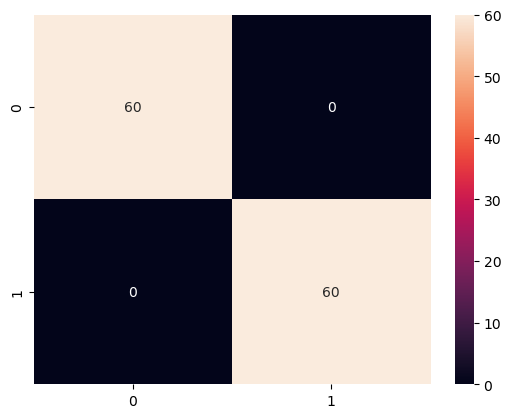

In [83]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds_class)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [85]:
#save model
model.save_model('PlanetaryComputerExamples/OpenDataChallenge/Data/Models/catboost_model_360vars.cbm')

Training and validation is done. Now to prediction

In [86]:
#Reading the coordinates for the submission
test_file = pd.read_csv('PlanetaryComputerExamples/OpenDataChallenge/Data/challenge_1_submission_template.csv')
test_file.head()



,Latitude and Longitude
0,"(10.18019073690894, 105.32022315786804)"
1,"(10.561107033461816, 105.12772097986661)"
2,"(10.623790611954897, 105.13771401411867)"
3,"(10.583364246115156, 105.23946127195805)"
4,"(10.20744446668854, 105.26844107128906)"


In [5]:
#read model
model = CatBoostClassifier()
model.load_model('PlanetaryComputerExamples/OpenDataChallenge/Data/Models/catboost_model.cbm')

In [ ]:
time_slice = "2020-01-04/2021-01-04"
assets = ['vh','vv']
coordinates=test_file['Latitude and Longitude']
datasets = []
for i in tqdm(range(0,len(coordinates))):
    data = db_scale(get_sentinel_data(coordinates[i],time_slice,assets, bbox_size_px = 5))
    data.mean(dim=['x','y']).compute()
    data.to_netcdf('PlanetaryComputerExamples/OpenDataChallenge/Data/SubmissionData/sub_data_' + str(i) + '.nc')
    datasets.append(data)


In [87]:
#get sample data from data files
dataArray = []
for i in tqdm(range(0,250)):
    data = xr.open_dataset('PlanetaryComputerExamples/OpenDataChallenge/Data/SubmissionData/sub_data_'+str(i)+'.nc')
    data = data.mean(dim=['x','y']).compute()
    dataArray.append(data)
data = xr.concat(dataArray, dim='place') 

100%|██████████| 250/250 [00:01<00:00, 148.30it/s]


In [88]:
data = data.resample(time='1D').max().compute()

In [89]:
data = data.interpolate_na(dim='time', method='cubic')

In [90]:
data

<xarray.Dataset>
Dimensions:      (time: 361, place: 250)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-09 2020-01-10 ... 2021-01-03
    spatial_ref  int32 32648
Dimensions without coordinates: place
Data variables:
    vh           (place, time) float32 -19.02 -20.4 -21.12 ... -19.86 -20.75
    vv           (place, time) float32 -18.31 -18.62 -18.36 ... -9.737 -8.484

In [91]:

crossCo = (data.vh/data.vv).to_dataset(name='crossCo')
data = data.merge(crossCo)

In [92]:
#apply time series smoothing
smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
smooth_data = []	
for i in tqdm(range(0,len(data.place))):
    smoother.smooth(data.isel(place=i).to_array(dim='time'))
    smooth_data.append(xr.DataArray(smoother.smooth_data, dims=['bands', 'time'], coords={'bands':['vv','vh','crossCo'], 'time':data.time}))


smooth_data = xr.concat(smooth_data, dim='place')

 

100%|██████████| 250/250 [00:05<00:00, 46.71it/s]


In [93]:
smooth_data = smooth_data.stack(variables=('bands', 'time'))
smooth_data

<xarray.DataArray (place: 250, variables: 1083)>
array([[-21.223188 , -20.92599  , -20.629297 , ...,   3.4213517,
          3.5381382,   3.6560318],
       [-17.849201 , -17.756533 , -17.664347 , ...,   2.2724252,
          2.3153527,   2.3584342],
       [-22.084944 , -21.898731 , -21.709774 , ...,   3.3469574,
          3.3747935,   3.3971457],
       ...,
       [-24.353777 , -24.372492 , -24.389767 , ...,   1.2087809,
          1.2007816,   1.1928049],
       [-21.354702 , -21.262596 , -21.163725 , ...,   2.3682315,
          2.3736048,   2.3769948],
       [-21.779963 , -21.529623 , -21.281525 , ...,   2.0820858,
          2.098446 ,   2.1143947]], dtype=float32)
Coordinates:
  * variables  (variables) object MultiIndex
  * bands      (variables) <U7 'vv' 'vv' 'vv' ... 'crossCo' 'crossCo' 'crossCo'
  * time       (variables) datetime64[ns] 2020-01-09 2020-01-10 ... 2021-01-03
Dimensions without coordinates: place

In [ ]:
#validate model
preds_class = model.predict(smooth_data.values)
preds_proba = model.predict_proba(smooth_data.values)
print("class = ", preds_class)
print("proba = ", preds_proba)

#plot distribution of predictions
plt.hist(preds_class)


In [95]:
#join predictions with coordinates
test_file['Class of Land'] = preds_class
test_file.head()

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice


In [97]:
#save predictions
test_file.to_csv('PlanetaryComputerExamples/OpenDataChallenge/Data/submission_5.csv', index=False)

In [102]:
#compare submission with submission_2
submission = pd.read_csv('PlanetaryComputerExamples/OpenDataChallenge/Data/submission_5.csv')
submission_2 = pd.read_csv('PlanetaryComputerExamples/OpenDataChallenge/Data/submission_4.csv')

#count number of differences
count = 0
for i in range(0,len(submission)):
    if submission['Class of Land'][i] != submission_2['Class of Land'][i]:
        count += 1
print(count)



3
